##### Copyright 2023 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


# How to work with insertion/deletion forward processes

This notebook shows how to construct and manipulate probability distributions  for discrete insertion/deletion diffusion processes, as described in ["Beyond In-Place Corruption: Insertion and Deletion in Denoising Probabilistic Models"](https://arxiv.org/abs/2107.07675).


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google-research/google-research/blob/master/d3pm/insertdelete/Insertion_and_Deletion_Forward_Process_Guide.ipynb)

### Setup and imports

In [10]:
!git clone https://github.com/google-research/google-research.git --depth=1 --no-checkout
!cd google-research
!git sparse-checkout init --cone
!git sparse-checkout set d3pm
!git switch master

Cloning into 'google-research'...
remote: Enumerating objects: 17221, done.
remote: Counting objects: 100% (17221/17221), done.
remote: Compressing objects: 100% (14097/14097), done.
remote: Total 17221 (delta 2630), reused 11246 (delta 2129), pack-reused 0
Receiving objects: 100% (17221/17221), 192.78 MiB | 20.72 MiB/s, done.
Resolving deltas: 100% (2630/2630), done.
Already on 'master'
Your branch is up to date with 'origin/master'.


In [42]:
!pip install "flax~=0.6.4"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
from d3pm.insertdelete import transition_operator
from d3pm.insertdelete import forward_process

In [14]:
import numpy as np
import jax
import jax.numpy as jnp

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.ion()

In [16]:
np.set_printoptions(linewidth=150)

## Constructing a distribution

In [17]:
def unstringify(s, max_len):
  """Converts a string to a wrapped sequence."""
  arr = np.full((max_len,), -3, dtype=np.int32)
  arr[:len(s)] = ["!x+abcdeABCDE".find(t)-3 for t in s]
  return forward_process.DynamicLengthSentinelSequence(arr, len(s))

def stringify_tok(tok):
  """Transforms a token into a string."""
  return "!x+abcdeABCDE"[tok+3]

def stringify(dyn_seq):
  """Transforms a sequence of tokens into a string."""
  return "".join("!x+abcdeABCDE"[t+3] for t in list(dyn_seq.tokens[:dyn_seq.length]))

def treeslice(i, obj):
  return jax.tree.map(lambda v: v[i], obj)

def treestack(objs):
  return jax.tree_multimap(lambda *args: jnp.stack(list(args)), *objs)

def tree_unstack(objs):
  length = jax.tree.leaves(objs)[0].shape[0]
  return [treeslice(i, objs) for i in range(length)]

def mk_A(swap_prob):
  """Builds a transition matrix that swaps lowercase and capital letters."""
  return transition_operator.LogMatrixOperator.from_probs(
      (1-swap_prob) * np.eye(10)
      + swap_prob * np.roll(np.eye(10), 5, 0))


def mk_D_logits(upper_prob):
  """Builds a vector of token probabilities for insertions."""
  return np.log(np.array([(1 - upper_prob)/5] * 5 + [upper_prob/5] * 5))

# High noise schedule
noise_test_0_to_1 = forward_process.OneStepDistn(
    lp_delete=jnp.log(0.3), lp_insert=jnp.log(0.41),
    A=mk_A(.21), D_insert_logits=mk_D_logits(.1))
noise_test_1_to_2 = forward_process.OneStepDistn(
    lp_delete=jnp.log(0.19), lp_insert=jnp.log(0.24),
    A=mk_A(.05), D_insert_logits=mk_D_logits(.3))
noise_test_2_to_3 = forward_process.OneStepDistn(
    lp_delete=jnp.log(0.34), lp_insert=jnp.log(0.23),
    A=mk_A(.08), D_insert_logits=mk_D_logits(.5))
noise_test_3_to_4 = forward_process.OneStepDistn(
    lp_delete=jnp.log(0.0), lp_insert=jnp.log(0.0),
    A=mk_A(.12), D_insert_logits=mk_D_logits(.7))

# Lower noise schedule; uncomment to try a different noise schedule.
# noise_test_0_to_1 = forward_process.OneStepDistn(
#     lp_delete=jnp.log(0.09), lp_insert=jnp.log(0.065),
#     A=mk_A(.031), D_insert_logits=mk_D_logits(.1))
# noise_test_1_to_2 = forward_process.OneStepDistn(
#     lp_delete=jnp.log(0.079), lp_insert=jnp.log(0.064),
#     A=mk_A(.011), D_insert_logits=mk_D_logits(.15))
# noise_test_2_to_3 = forward_process.OneStepDistn(
#     lp_delete=jnp.log(0.034), lp_insert=jnp.log(0.023),
#     A=mk_A(.021), D_insert_logits=mk_D_logits(.5))
# noise_test_3_to_4 = forward_process.OneStepDistn(
#     lp_delete=jnp.log(0.0), lp_insert=jnp.log(0.0),
#     A=mk_A(.041), D_insert_logits=mk_D_logits(.7))

noise_test_multi_0_to_0 = forward_process.ManyStepDistn.identity_for(noise_test_0_to_1)
noise_test_multi_0_to_1 = noise_test_multi_0_to_0.then(noise_test_0_to_1, check=True)
noise_test_multi_0_to_2 = noise_test_multi_0_to_1.then(noise_test_1_to_2, check=True)
noise_test_multi_0_to_3 = noise_test_multi_0_to_2.then(noise_test_2_to_3, check=True)
noise_test_multi_0_to_4 = noise_test_multi_0_to_3.then(noise_test_3_to_4, check=True)

## Helper functions

In [18]:
def show_aligned(sequences, alignments, ax=None, figsize=(5,5), fontsize=18):
  """Visualizes a trajectory of aligned sequences."""
  max_length = 0
  if ax is None:
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()

  if alignments == "onestep":
    alignments = []
    for xt, xtplus1 in zip(sequences[:-1], sequences[1:]):
      alignments.append(forward_process.align_one_step(xt, xtplus1))

  for y, seq in enumerate(sequences):
    seqstr = stringify(seq)
    max_length = max(max_length, len(seqstr))
    for x, char in enumerate(seqstr):
      ax.text(x, y, char, ha="center", va="center", fontsize=fontsize)

  for y, align in enumerate(alignments):
    if align.reroll_mask is None:
      colors = np.full_like(align.backpointers, 2)
    else:
      colors = np.where(align.reroll_mask, 1, 0)
    colors = np.where(align.delete_sentinels, 3, colors)[:align.after_length]
    for x, (backptr, c) in enumerate(zip(align.backpointers[:align.after_length], colors)):
      if backptr == forward_process.SequenceAlignment.NO_BACKPOINTER:
        continue
      ax.plot([backptr, x], [y + 0.2, y+1 - 0.2], c=mpl.cm.tab10(c))

  ax.set_xlim((-.5, max_length-.5))
  ax.set_ylim((-.5, len(sequences)-.5))
  ax.invert_yaxis()


In [19]:
def show_marginals(sequence, marginal, figsize=(5,5), fontsize=18, ax=None, clip_deletes=6, num_alts=3):
  """Visualizes a vector of marginal probabilities."""

  if ax is None:
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()

  seqlen = sequence.length
  if clip_deletes:
    max_deletes = clip_deletes
  else:
    max_deletes = marginal.log_prob_number_of_preceding_deletes.shape[1]

  seqstr = stringify(sequence)
  for x, char in enumerate(seqstr):
    ax.text(x, -1, char, ha="center", va="center", fontsize=fontsize)

  for i in range(seqlen):
    best_toks = np.argsort(-marginal.previous_token_log_probs[i])
    for j, tok in enumerate(best_toks[:num_alts]):
      alpha = np.exp(marginal.previous_token_log_probs[i, tok])
      ax.text(i, -3-j, stringify_tok(tok), ha="center", va="center", fontsize=fontsize, alpha=alpha)


  ax.imshow(jnp.exp(marginal.log_prob_number_of_preceding_deletes[:seqlen+1, :]).T, cmap=mpl.cm.Reds, vmin=0, vmax=1)#, extent=(-0.5, max_deletes-0.5, -0.5, seqlen-0.5))
  ax.imshow(jnp.exp(marginal.was_insert_log_prob)[None, :seqlen], extent=(-0.5, seqlen-0.5, -2.5, -1.5), cmap=mpl.cm.Blues, vmin=0, vmax=1)

  ax.set_xlim((-.5, seqlen+.5))
  ax.set_ylim((-2.5-num_alts, max_deletes-.5))


## Working with insertion-deletion forward processes

### Sampling one step

+axx++De


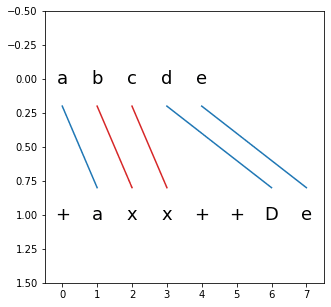

In [20]:
# Generate one random sample using the 0->1 transition probabilities.
seq, alignment = forward_process.sample_noise_step(
    sequence=unstringify("abcde", 32),
    distn=noise_test_0_to_1,
    rng=jax.random.PRNGKey(0))
print(stringify(seq))
show_aligned([unstringify("abcde", 32), seq], [alignment])

In this sample:
- multiple new insertion sentinel tokens ("+") are inserted
- b and c are replaced with delete sentinels ("x")
- "a" and "e" are copied unchanged
- "d" is modified into "D"

In [21]:
# Generate a number of random samples using the 1->2 transition probabilities.
seqs, alignments = jax.vmap(lambda rng: forward_process.sample_noise_step(
    sequence=unstringify('axcx++e+', 32),
    distn=noise_test_1_to_2,
    rng=rng))(jax.random.split(jax.random.PRNGKey(0), 30))
[stringify(s) for s in tree_unstack(seqs)]

<ipython-input-17-cfef1419032b>:22: FutureWarning: jax.tree.leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  length = jax.tree.leaves(objs)[0].shape[0]


['++a+cdbex',
 'ac++cded',
 'xCce++ea',
 'acd+eed+',
 '+acD+Eex',
 'xCeBeB++',
 '++acc+xeb',
 'acdxx+b',
 'xxD++++bex',
 'xc+e+axx',
 'a+ccBeB',
 'acabx+x',
 'x+ce+dec',
 'a++cCde+E+',
 'xcxDeD',
 'ax+xxex++',
 'xcdd+ec',
 'axedeB',
 'A+x+bBex',
 '++a+cea+ex',
 '+a+CBBec',
 'x+cxbe+a+',
 'ac+bcxD+',
 'axc+Cea',
 '+a++cA+d++xd',
 'acDEea',
 '+a+cxAxx',
 'ac++bde+b',
 'accae+c',
 'xcbxeA+']

### Sampling multiple steps

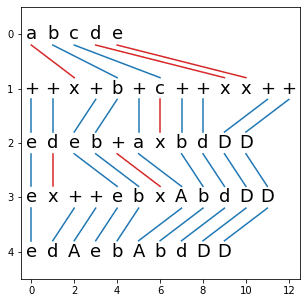

In [22]:
rng = jax.random.PRNGKey(1)

cur_sequence = unstringify("abcde", 32)
sequences = [cur_sequence]
alignments = []
for distn in [noise_test_0_to_1,
              noise_test_1_to_2,
              noise_test_2_to_3,
              noise_test_3_to_4]:
  rng, key = jax.random.split(rng)
  cur_sequence, alignment = forward_process.sample_noise_step(
    sequence=cur_sequence,
    distn=distn,
    rng=key)
  sequences.append(cur_sequence)
  alignments.append(alignment)

show_aligned(sequences, alignments)

### Inferring one-step alignments

It is always possible to deterministically infer an alignment for adjacent sequences.

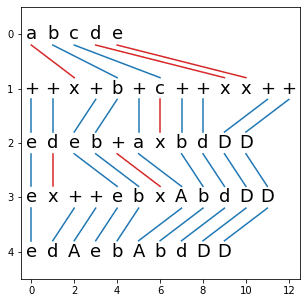

In [23]:
inferred_alignments = [forward_process.align_one_step(s1, s2) for s1, s2 in zip(sequences[:-1], sequences[1:])]
show_aligned(sequences, inferred_alignments)

### Expanding to multi-step alignments

We can skip timesteps and chain the alignments together.

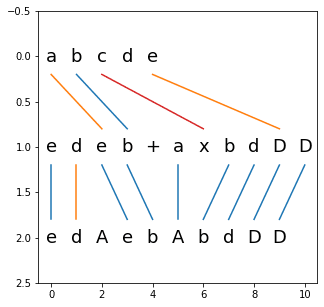

In [24]:
show_aligned(
    [sequences[0], sequences[2], sequences[4]],
    [
      alignments[0].then(alignments[1]),
      alignments[2].then(alignments[3])
    ])

Orange lines here represent "reroll" alignments: a token was deleted, but before it was deleted, another token was inserted to the right of it. Keeping track of these alignments is necessary to avoid ambiguities across consecutive insertions and deletions.

### Sampling multiple steps at once

We can chain together multiple distributions, then sample from the chained distribution. This is statistically equivalent to rolling out samples from the individual steps, but can be done more efficiently.

In [25]:
start = unstringify('axcx++e+', 32)
seqs, alignments = jax.vmap(lambda rng: forward_process.sample_noise_step(
    sequence=start,
    distn=forward_process.ManyStepDistn.from_single_step(noise_test_1_to_2).then(noise_test_2_to_3),
    rng=rng))(jax.random.split(jax.random.PRNGKey(0), 30))

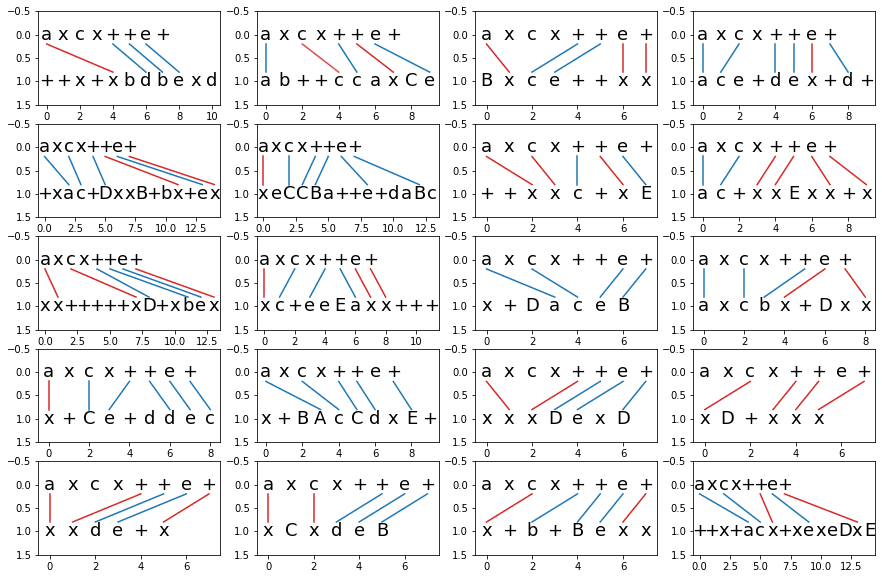

In [26]:
fig, axs = plt.subplots(ncols=4, nrows=5, figsize=(15, 10))
for i in range(axs.size):
  show_aligned([start, treeslice(i, seqs)], [treeslice(i, alignments)], ax=axs[np.unravel_index(i, axs.shape)])

### Computing log probs

We can use our distributions to compute the (log of the) probability of obtaining a particular sequence after another. If we have a fixed alignment, this is straightforward to compute.

In [27]:
forward_process.multi_step_aligned_log_prob(
    unstringify('axcx+e+', 32),
    unstringify('xc++xex', 32),
    forward_process.align_one_step(unstringify('axcx+e+', 32), unstringify('xc++xex', 32)),
    forward_process.ManyStepDistn.from_single_step(noise_test_1_to_2),
)

DeviceArray(-10.007076, dtype=float32)

Over multiple steps, we can still compute log probs, as long as we have a multi-step alignment. (Note that this is the probability of observing this alignment and also this output,  marginalized over intermediate steps.)

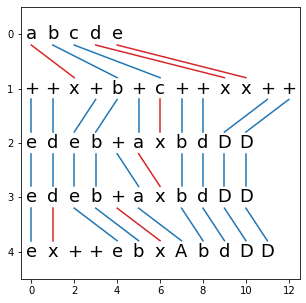

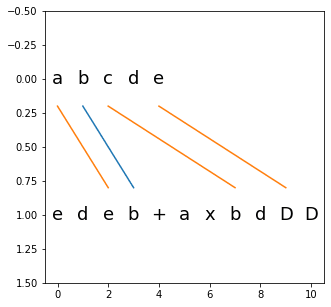

In [28]:
# Set up some sequences
sequence_strings = [
  'abcde',
  '++x+b+c++xx++',
  'edeb+axbdDD',
  'edeb+axbdDD',
  'ex++ebxAbdDD',
]
sequences = [unstringify(s, 16) for s in sequence_strings]
inferred_alignments = [forward_process.align_one_step(s1, s2) for s1, s2 in zip(sequences[:-1], sequences[1:])]
show_aligned(sequences, inferred_alignments)
show_aligned([sequences[0], sequences[3]], [inferred_alignments[0].then(inferred_alignments[1]).then(inferred_alignments[2])])

In [29]:
forward_process.multi_step_aligned_log_prob(
    source=sequences[0],
    target=sequences[3],
    distn=noise_test_multi_0_to_3,
    alignment=inferred_alignments[0].then(inferred_alignments[1]).then(inferred_alignments[2]))

DeviceArray(-41.96258, dtype=float32)

### Resampling intermediate values conditioned on an alignment

Given sequences at times 0 and T, and an alignment between them, we can sample an intermediate sample at time T-1. This produces the same overall distribution of samples as sampling each of the timesteps in the original order, but allows us to generate multiple hypothetical intermediate states given a fixed final state.

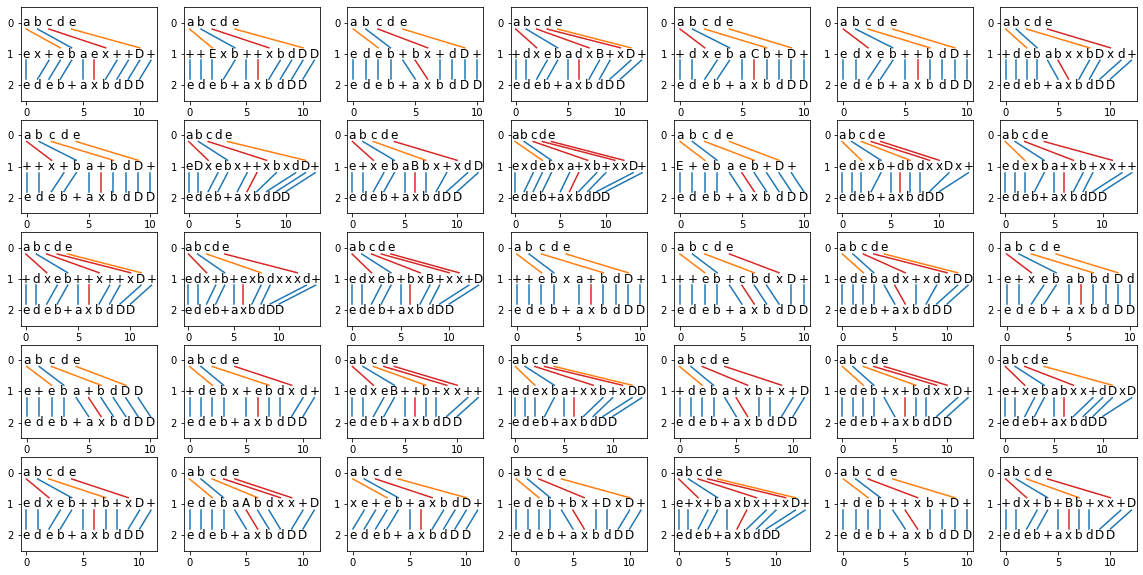

In [30]:
x0 = sequences[0]
x3 = sequences[3]
alignment_0_to_3 = inferred_alignments[0].then(inferred_alignments[1]).then(inferred_alignments[2])

key = jax.random.PRNGKey(1)

def sample_one_intermediate(key):
  return forward_process.sample_intermediate(
      x0, x3, alignment_0_to_3, noise_test_multi_0_to_2, noise_test_2_to_3, key)

(x2, alignment_0_to_t, alignment_t_to_tplus1) = jax.vmap(sample_one_intermediate)(jax.random.split(key, 5 * 7))


fig, axs = plt.subplots(ncols=7, nrows=5, figsize=(20, 10))
for i in range(axs.size):
  show_aligned([x0, treeslice(i, x2), x3], treeslice(i, [alignment_0_to_t, alignment_t_to_tplus1]), ax=axs[np.unravel_index(i, axs.shape)], fontsize=12)


Note that this allows us to sample in reverse! We can:

- choose our starting sequence at time 0,
- use multi-step sampling to directly sample the output at the final timestep T,
- then repeatedly use `sample_intermediate` to generate a sequence at time T-1, then again at time T-2, and so on, until we have generated values for all timesteps.

### Intermediate marginals

Instead of sampling individual intermediate sequences, we can also compute "marginals". These give probabilities of previous tokens aggregated at a per-token level.

In [31]:
marginals, expected_log_prob = forward_process.intermediate_marginals(x0, x3, alignment_0_to_3, noise_test_multi_0_to_2, noise_test_2_to_3)
print(expected_log_prob)

-17.218935


/usr/local/lib/python3.8/dist-packages/jax/_src/numpy/lax_numpy.py:3463: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


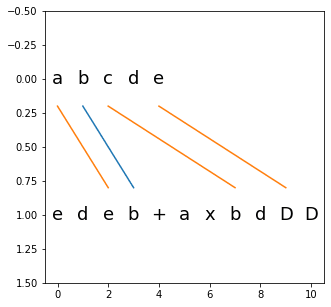

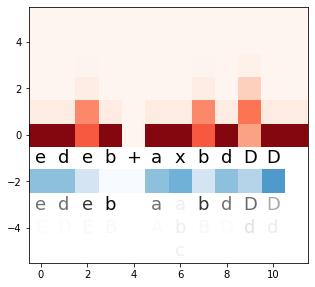

In [32]:
show_aligned([x0, x3], [alignment_0_to_3])
show_marginals(x3, marginals)

In this plot:
- The letters in the middle (at row -1) are the tokens in the sequence `x3`, same as they appear in the previous figure.
- Red denotes probability of there being a given number of delete tokens at time T-1 that existed before the token in the middle at time T, with higher squares denoting more delete tokens (e.g. a red square at 0 is the probability of no delete tokens, a red square one step above is the probability of one, and so on). Note that we don't compute anything here for insert tokens because the insert tokens did not exist at time T-1. Also, delete tokens are more likely to have appeared before reroll alignments (orange lines in the top plot), since the reroll alignments are only generated by combinations of insertions and deletions.
- Blue denotes the probability that this token at time T used to be an insert token at time T-1.
- Gray letters below the blue denote possible values for this token at the previous step, and are ranked and shaded based on their likelihood at previous steps. Due to the configuration of the transition matrix in the setup section above, letters are most likely to have stayed the same, but some letters could have switched capitalization, and a delete sentinel at time T could have been any token at time T-1.

These marginals are important because they serve as the output representation for our neural network models. These models are given the sequence at time T (e.g. the sequence shown in the middle of the plot), and they predict distributions over inserts, previous token values, and numbers of previous deletion sentinels.

We can also sample a new sequence from these marginals. Note that this is *NOT* statistically equivalent to running `sample_intermediate`, since `sample_intermediate` keeps track of interactions between tokens and the marginals do not. However, the less noise there is in the forward process, the less uncertainty there is in the marginals, so sampling from the marginals can produce a good approximation of the distribution we want. When sampling from our learned models, we use this approach, since our model only learns the marginals.

In [33]:
for i in range(10):
  sample_from_marginals = marginals.sample(jax.random.PRNGKey(i))
  print(stringify(sample_from_marginals))


+d+b++bd++
e+ebacxbx+x++
+deb++bdxDD
e+exbxab++xd+
+deBaEbdxD+
++x+ba+B+xx+D
e+ebaEx+dx+D
++ebaD+dx++
++eb++b+xDD
ed+xxba++xdx++


### Resampling multi-step alignments

If we don't have an alignment between the initial and final sequence, it's also possible to infer one using dynamic programming across multiple steps of the sequence. (Note that this is much more expensive than using a single fixed alignment; when training a model it ends up being more efficient to just remember the original alignment.)

The first step is to compute a table of possible token-level alignments between sequences.

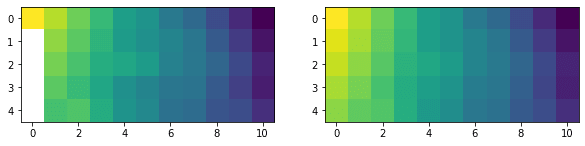

In [34]:
alignment_table = forward_process.compute_multi_step_alignment_table(
    x0,
    x3,
    noise_test_multi_0_to_3)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
axs[0].imshow(alignment_table[0][:x0.length,:x3.length])
axs[1].imshow(alignment_table[1][:x0.length,:x3.length])

Given this, we can then sample individual alignments using an iterative process (somewhat similar to sampling from the posterior of a hidden Markov model).

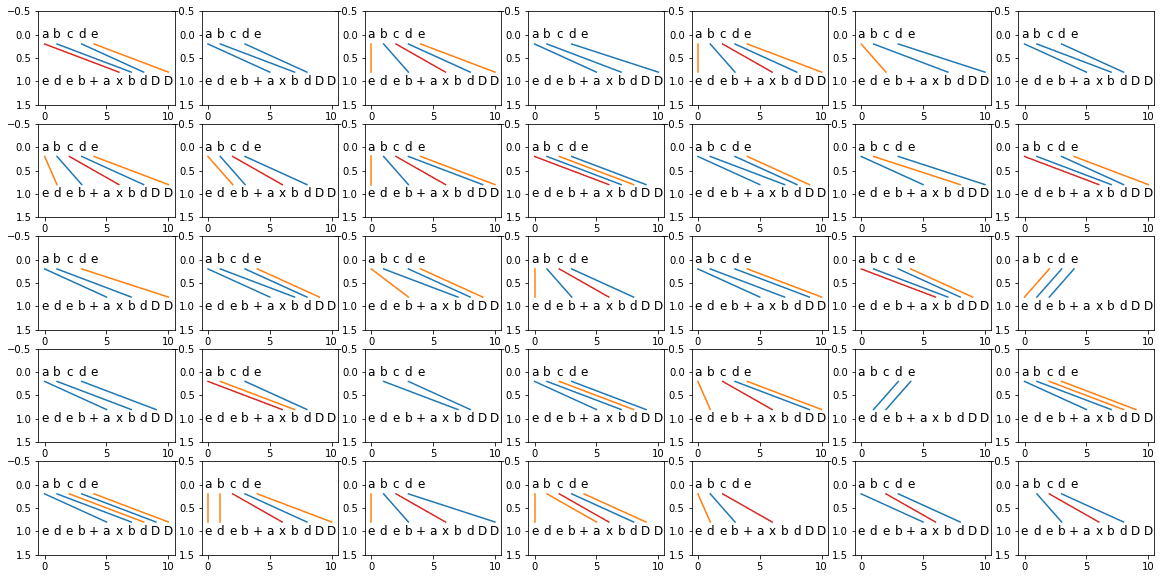

In [35]:
def sample_one_alignment(key):
  return forward_process.sample_alignment_from_table(
      source=x0,
      target=x3,
      distn=noise_test_multi_0_to_3,
      alignment_table=alignment_table,
      rng=key)

key = jax.random.PRNGKey(2)
alignments_stacked = jax.vmap(sample_one_alignment)(jax.random.split(key, 5 * 7))


fig, axs = plt.subplots(ncols=7, nrows=5, figsize=(20, 10))
for i in range(axs.size):
  show_aligned([x0, x3], treeslice(i, [alignments_stacked]), ax=axs[np.unravel_index(i, axs.shape)], fontsize=12)


#### Advanced: Rao-Blackwell over a reduced dynamic programming table

An advanced trick is to only compute the DP table for entries that are close to the diagonal, which can be more efficient for large sequences.

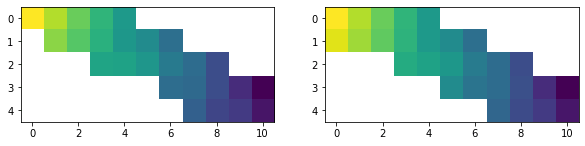

In [36]:
alignment_table_banded = forward_process.compute_multi_step_alignment_table(
    x0,
    x3,
    noise_test_multi_0_to_3,
    pack_block_size=2,
    use_dynamic_band=True)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
axs[0].imshow(alignment_table_banded[0][:x0.length,:x3.length])
axs[1].imshow(alignment_table_banded[1][:x0.length,:x3.length])

Note that if we sample an alignment using this table, it will only sample an alignment that matches tokens that are close to one another spatially, and won't do large numbers of consecutive insertions or deletions.

If we want to average something over all alignments, we can use a trick called Rao-Blackwellization or conditional marginalization:
- if our original sample was contained in this diagonal "dynamic band", we can draw a bunch of other samples within that dynamic band, and average over them
- if our original sample was not contained in the band, we just keep the value from our original sample.

It turns out that this has less variance than just using the original sample's value, if we want to estimate some quantity across all possible alignments. However, this ends up being quite slow in practice, and isn't usually worth doing.

If we use the originally sampled alignment, it is in the band, and we can resample other well-aligned alignments using our table.

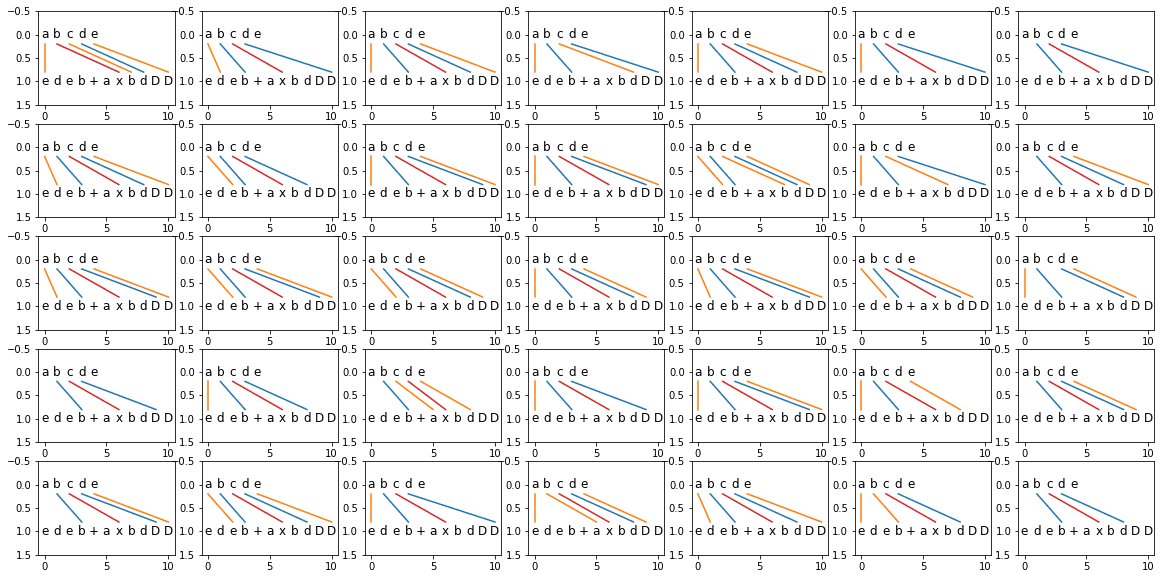

In [37]:
def sample_one_alignment(key):
  return forward_process.rao_blackwellize_dynamic_band_alignment(
      source=x0,
      target=x3,
      distn=noise_test_multi_0_to_2,
      alignment=alignment_0_to_3,
      alignment_table=alignment_table_banded,
      rng=key)

key = jax.random.PRNGKey(2)
alignments_stacked = jax.vmap(sample_one_alignment)(jax.random.split(key, 5 * 7))

fig, axs = plt.subplots(ncols=7, nrows=5, figsize=(20, 10))
for i in range(axs.size):
  show_aligned([x0, x3], treeslice(i, [alignments_stacked]), ax=axs[np.unravel_index(i, axs.shape)], fontsize=12)


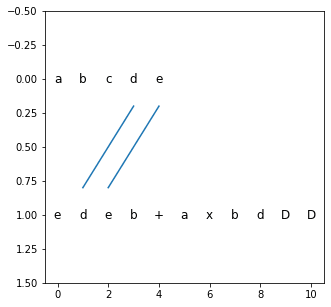

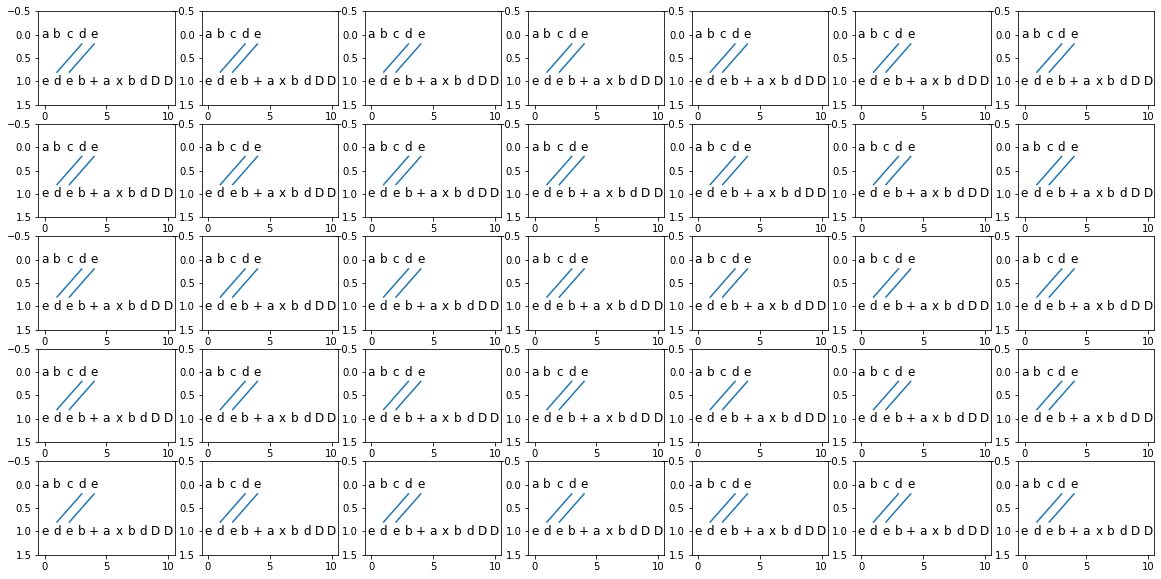

In [38]:
# This is the sampled alignment at indes 26 in `alignments_stacked` above.
# It's a possible alignment, but it requires a large number of insertions.
out_of_band_alignment = forward_process.SequenceAlignment(
    backpointers=jnp.array([-1,  3,  4, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]),
    delete_sentinels=jnp.array([0, 0, 0, 0, 0, 0,  1, 0, 0, 0, 0, 0, 0, 0, 0, 0]).astype(bool),
    before_length=jnp.array(5),
    after_length=jnp.array(11),
    is_single_step=False,
    reroll_mask=jnp.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]).astype(bool))

show_aligned([x0, x3], [out_of_band_alignment], fontsize=12)

def sample_one_alignment(key):
  return forward_process.rao_blackwellize_dynamic_band_alignment(
      source=x0,
      target=x3,
      distn=noise_test_multi_0_to_2,
      alignment=out_of_band_alignment,  # uses our manual assignment instead
      alignment_table=alignment_table_banded,
      rng=key)

key = jax.random.PRNGKey(2)
alignments_stacked = jax.vmap(sample_one_alignment)(jax.random.split(key, 5 * 7))

fig, axs = plt.subplots(ncols=7, nrows=5, figsize=(20, 10))
for i in range(axs.size):
  show_aligned([x0, x3], treeslice(i, [alignments_stacked]), ax=axs[np.unravel_index(i, axs.shape)], fontsize=12)


### Computing the number of tokens at the final timestep

For simplicity, we assume that the final step of the forward process deletes everything. This means that the only information left at the final timestep is just the number of deletions that happened.

In [39]:

# Main schedule
noise_test_0_to_1 = forward_process.OneStepDistn(
    lp_delete=jnp.log(0.3), lp_insert=jnp.log(0.35),
    A=mk_A(.21), D_insert_logits=mk_D_logits(.1))
noise_test_1_to_2 = forward_process.OneStepDistn(
    lp_delete=jnp.log(0.19), lp_insert=jnp.log(0.14),
    A=mk_A(.15), D_insert_logits=mk_D_logits(.3))
noise_test_2_to_3 = forward_process.OneStepDistn(
    lp_delete=jnp.log(0.34), lp_insert=jnp.log(0.23),
    A=mk_A(.18), D_insert_logits=mk_D_logits(.5))
noise_test_3_to_4 = forward_process.OneStepDistn(
    lp_delete=jnp.log(0.4), lp_insert=jnp.log(0.2),
    A=mk_A(.12), D_insert_logits=mk_D_logits(.7))

# Last step deletes everything
noise_test_4_to_5_terminal = forward_process.OneStepDistn(
    lp_delete=jnp.log(1.0), lp_insert=jnp.log(0.0),
    A=mk_A(.5), D_insert_logits=mk_D_logits(.5))

noise_test_multi_0_to_0 = forward_process.ManyStepDistn.identity_for(noise_test_0_to_1)
noise_test_multi_0_to_1 = noise_test_multi_0_to_0.then(noise_test_0_to_1, check=True)
noise_test_multi_0_to_2 = noise_test_multi_0_to_1.then(noise_test_1_to_2, check=True)
noise_test_multi_0_to_3 = noise_test_multi_0_to_2.then(noise_test_2_to_3, check=True)
noise_test_multi_0_to_4 = noise_test_multi_0_to_3.then(noise_test_3_to_4, check=True)
noise_test_multi_0_to_5_terminal = noise_test_multi_0_to_4.then(noise_test_4_to_5_terminal, check=True)

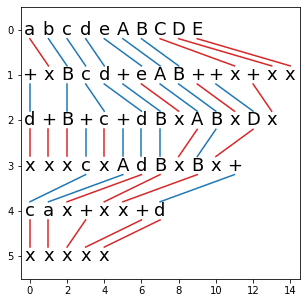

In [40]:
rng = jax.random.PRNGKey(1)

x0 = unstringify("abcdeABCDE", 64)
cur_sequence = x0
sequences = [cur_sequence]
alignments = []
for distn in [noise_test_0_to_1,
              noise_test_1_to_2,
              noise_test_2_to_3,
              noise_test_3_to_4,
              noise_test_4_to_5_terminal]:
  rng, key = jax.random.split(rng)
  cur_sequence, alignment = forward_process.sample_noise_step(
    sequence=cur_sequence,
    distn=distn,
    rng=key)
  sequences.append(cur_sequence)
  alignments.append(alignment)

show_aligned(sequences, alignments)

We can directly compute the distribution of final step lengths without sampling.

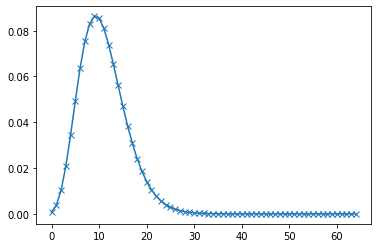

In [41]:
terminal_length_log_probs = forward_process.terminal_sentinel_distribution(x0, noise_test_multi_0_to_5_terminal)
terminal_length_probs = np.exp(terminal_length_log_probs)
plt.plot(np.arange(terminal_length_log_probs.shape[0]), terminal_length_probs, "x-")

Note that this distribution depends on the number of tokens in the original input, which will be different for different dataset samples. We train our models to predict a version of this distribution averaged across many dataset samples. To use it for generation, we sample a number of sentinels for time T according to our learned copy of this distribution, then run our model to try to infer the token values that existed at time T-1.